In [1]:
#Import needed packages
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

#Import model and visualization functions
import sys 
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/data')
from support_vector_machine import support_vector_machine
from randomforest_classifier import randomforest_classifier
from decision_tree_classifier import decision_tree_classifier
from plot_results import plot_results
from combine_tables import combine_tables
from playground import playground

#Import our data
log_returns_currencies = pd.read_csv("../data/processed/log_returns_currency_data.csv")
log_returns_spx = pd.read_csv("../data/processed/log_returns_spx_data.csv")
dataframe = pd.merge(log_returns_currencies, log_returns_spx.iloc[1:], on='DATE', how='inner')
print(dataframe)

            DATE   USDEUR   USDJPY   USDGBP   USDCHF   USDAUD   USDCAD  \
0     2000-01-04 -0.01505 -0.01358 -0.00613  0.01549  0.00441 -0.00366   
1     2000-01-05 -0.00252 -0.00657 -0.00275  0.00251  0.00183  0.00000   
2     2000-01-06  0.00106 -0.01359 -0.00365 -0.00090  0.00153 -0.00364   
3     2000-01-07  0.00291  0.00019  0.00554 -0.00533 -0.00122  0.00454   
4     2000-01-10  0.00409 -0.00105  0.00061 -0.00517 -0.00198 -0.00433   
...          ...      ...      ...      ...      ...      ...      ...   
5952  2023-11-17 -0.00258  0.00513 -0.00056  0.00135 -0.00463  0.00247   
5953  2023-11-20 -0.00605  0.01047 -0.00602  0.00327 -0.00965  0.00146   
5954  2023-11-21  0.00201  0.00257 -0.00279  0.00113 -0.00168  0.00219   
5955  2023-11-22  0.00477 -0.01203  0.00576 -0.00249  0.00504 -0.00314   
5956  2023-11-24 -0.00578  0.00067 -0.01061  0.00396 -0.00747  0.00914   

       USDNZD   USDSEK   USDSGD   USDNOK    SP500  
0     0.01072  0.00988  0.00169  0.00377 -0.03910  
1     0

In [6]:
#Select the number of days lag for our models
lag = 1
#Choose whether to use a random seed when training the models, if random_seed is false, standard_seed is used
random_seed = False
#Select the size of the training dataset (%)
train_size = 0.8
#Specify which currencies to use in the analysis
currencies = ['USDEUR', 'USDJPY', 'USDGBP', 'USDCHF', 'USDAUD', 'USDCAD', 
              'USDNZD', 'USDSEK', 'USDSGD', 'USDNOK']
#Choose whether S&P 500 should be used as a regressor variable
include_sp500 = True
#Should the strategy be long only?
long_only = False

In [7]:
#Train the models and print their accuracies
dt_accuracies, dt_results = decision_tree_classifier(dataframe, currencies, include_sp500, lag, train_size, random_seed, long_only)
rf_accuracies, rf_results = randomforest_classifier(dataframe, currencies, include_sp500, lag, train_size, random_seed, long_only)
svm_accuracies, svm_results = support_vector_machine(dataframe, currencies, include_sp500, lag, train_size, random_seed, long_only)


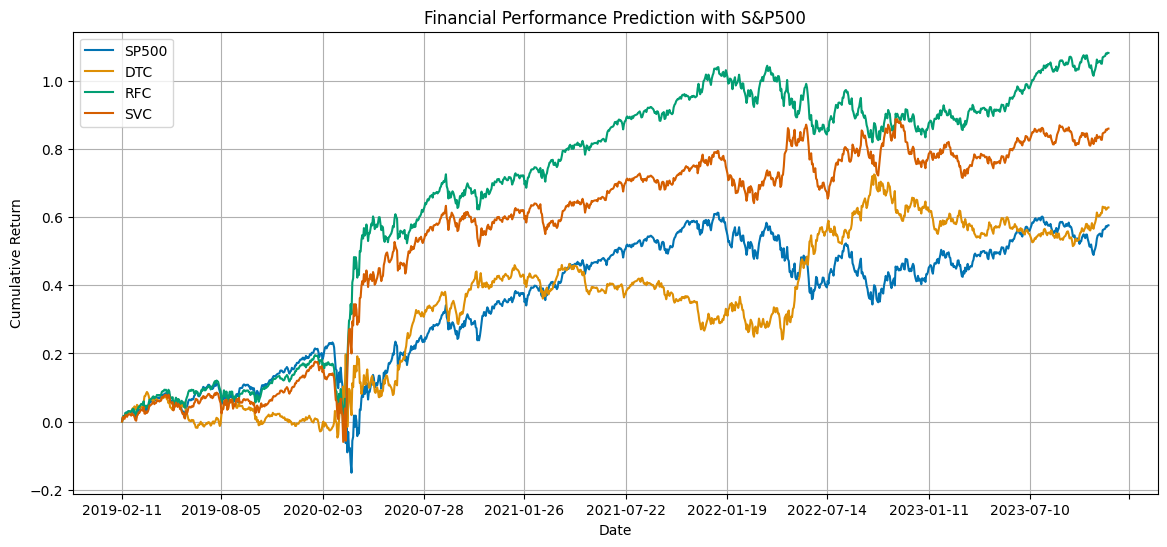

In [8]:
results = combine_tables([dt_results, rf_results,svm_results])
#Combine results tables
#result_df = pd.merge(svm_results, dt_results, on='ID')
#Plot the results

plot_results(results, include_sp500)


Dropdown(description='Select Model:', options=('Decision Tree Classifier', 'Random Forest Classifier', 'Suppor…

Output()

Button(description='Submit', style=ButtonStyle())

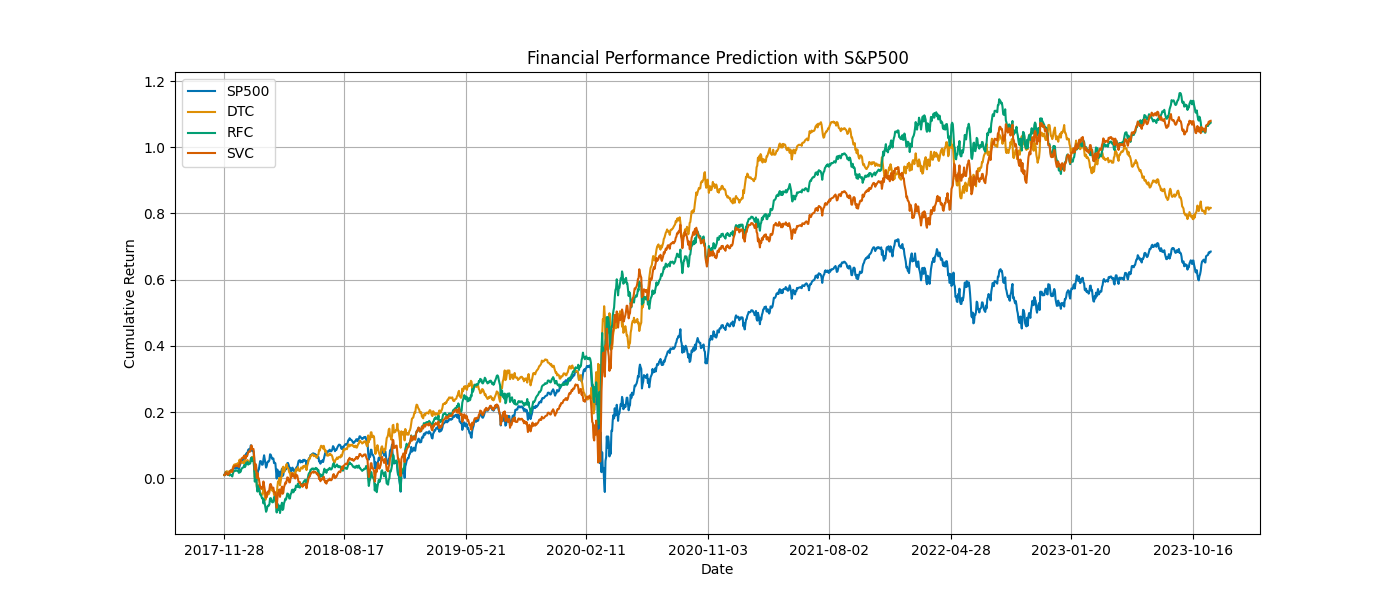

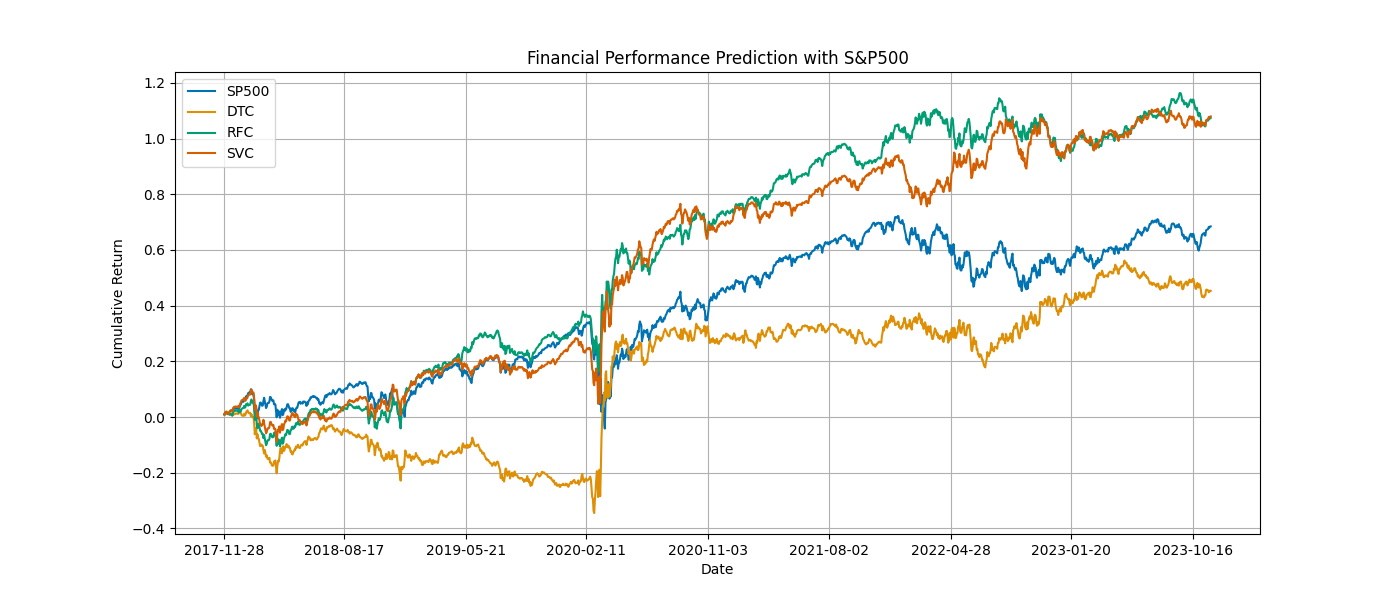

In [2]:
playground()

simulation with different seeds, different settings, etc.
also write some text
which predictor is the best? which model is the best?